# **Course: Natural Language Processing (CS221.Q12)**
**Member:** 
- Nguyen Cong Phat - 23521143
- Nguyen Le Phong - 23521168
- Pham Tran Khanh Duy - 23520384

## **0. Install libraries**

In [1]:
!pip -q install sklearn-crfsuite==0.3.6
!pip -q install pytorch-crf --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.9 MB/s eta 0:00:00:00:01


## **1. Import + setup path**

In [2]:
import os, re, random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn

from sklearn.metrics import classification_report, f1_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MODEL_DIR = "/kaggle/working/models"
OUT_DIR   = "/kaggle/working/outputs"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
print("MODEL_DIR:", MODEL_DIR)
print("OUT_DIR:", OUT_DIR)


device: cpu
MODEL_DIR: /kaggle/working/models
OUT_DIR: /kaggle/working/outputs


## **2. Auto detect dataset**

In [3]:
def find_kaggle_data_dir(hint="vlsp"):
    base = "/kaggle/input"
    if not os.path.isdir(base):
        return "."
    dirs = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
    if not dirs:
        return "."
    hint = hint.lower()
    dirs = sorted(dirs, key=lambda x: (hint not in x.lower(), x))
    return os.path.join(base, dirs[0])

DATA_DIR = find_kaggle_data_dir("dataset") 
TRAIN_PATH = os.path.join(DATA_DIR, "train.txt")
TEST_PATH  = os.path.join(DATA_DIR, "test.txt")

print("DATA_DIR:", DATA_DIR)
print("train exists:", os.path.exists(TRAIN_PATH))
print("test exists :", os.path.exists(TEST_PATH))


DATA_DIR: /kaggle/input/dataset
train exists: True
test exists : True


## **3. Load dataset and split train/val**

In [4]:
def load_conll(path):
    sents, tags = [], []
    ws, ts = [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if ws:
                    sents.append(ws); tags.append(ts)
                    ws, ts = [], []
                continue
            parts = line.split()
            if len(parts) < 2: 
                continue
            ws.append(parts[0])
            ts.append(parts[-1])
    if ws:
        sents.append(ws); tags.append(ts)
    return sents, tags

def train_valid_split(sents, tags, valid_ratio=0.1, seed=42):
    data = list(zip(sents, tags))
    random.Random(seed).shuffle(data)
    cut = int(len(data) * (1 - valid_ratio))
    tr, va = data[:cut], data[cut:]
    tr_s, tr_y = zip(*tr)
    va_s, va_y = zip(*va)
    return list(tr_s), list(tr_y), list(va_s), list(va_y)

sentences, labels = load_conll(TRAIN_PATH)
tr_s, tr_y, va_s, va_y = train_valid_split(sentences, labels, valid_ratio=0.1, seed=SEED)

test_s, test_y = load_conll(TEST_PATH) if os.path.exists(TEST_PATH) else ([], [])

print("Train:", len(tr_s), "Valid:", len(va_s), "Test:", len(test_s))
print("Example:", tr_s[0][:15])
print("Tags   :", tr_y[0][:15])


Train: 12137 Valid: 1349 Test: 3372
Example: ['Miền', 'Nam', 'gọi', 'súng', '.']
Tags   : ['B-LOC', 'I-LOC', 'O', 'O', 'O']


## **4. VISUALIZE DATA**

Sentence length: min=1 max=118 mean=21.84 median=19.00 p95=46.00


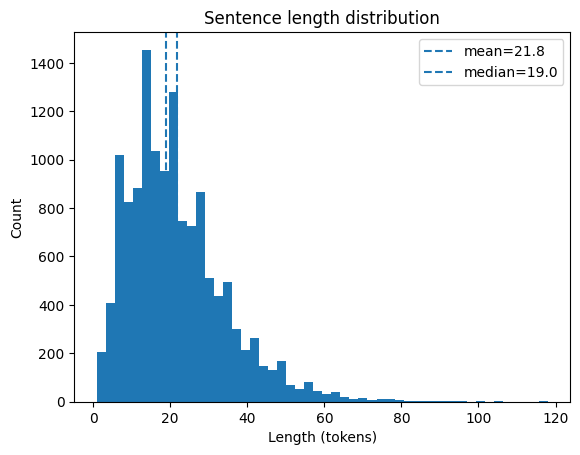

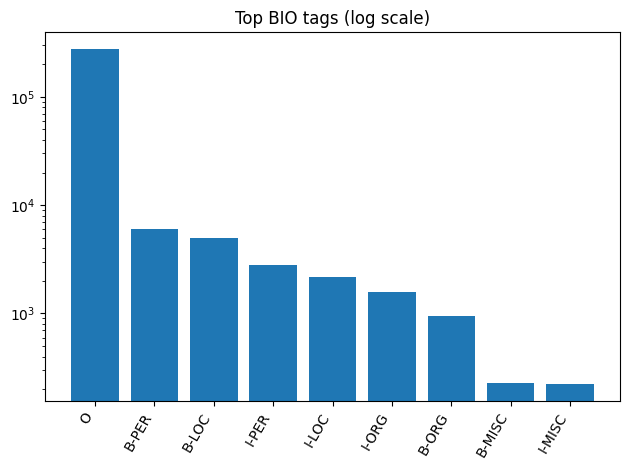

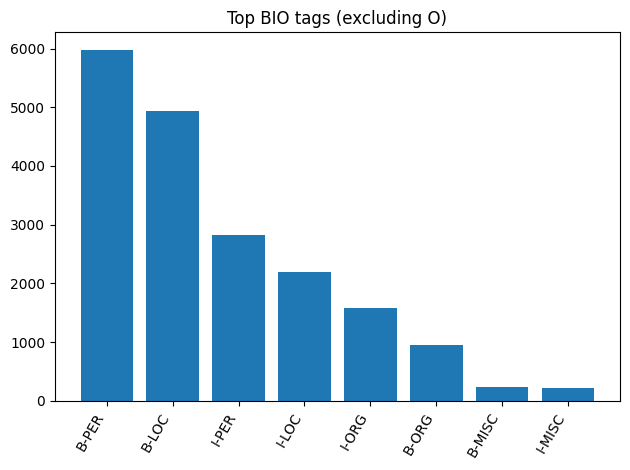

Entity type distribution:
  PER: 8807 (46.60%)
  LOC: 7119 (37.66%)
  ORG: 2524 (13.35%)
  MISC: 451 (2.39%)


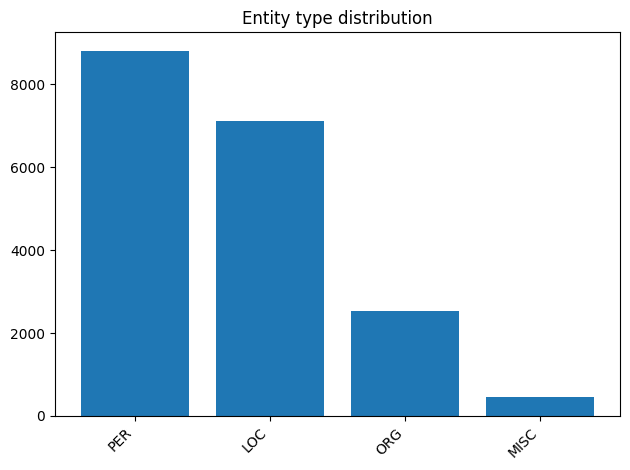

In [5]:
lens = np.array([len(s) for s in sentences])
print(f"Sentence length: min={lens.min()} max={lens.max()} mean={lens.mean():.2f} median={np.median(lens):.2f} p95={np.percentile(lens,95):.2f}")

plt.figure()
plt.hist(lens, bins=50)
plt.title("Sentence length distribution")
plt.xlabel("Length (tokens)")
plt.ylabel("Count")
plt.axvline(lens.mean(), linestyle="--", label=f"mean={lens.mean():.1f}")
plt.axvline(np.median(lens), linestyle="--", label=f"median={np.median(lens):.1f}")
plt.legend()
plt.show()

tag_cnt = Counter(t for seq in labels for t in seq)
top_tags = tag_cnt.most_common(30)

plt.figure()
plt.bar([t for t,_ in top_tags], [c for _,c in top_tags])
plt.yscale("log")
plt.xticks(rotation=60, ha="right")
plt.title("Top BIO tags (log scale)")
plt.tight_layout()
plt.show()

tag_cnt_noO = Counter({k:v for k,v in tag_cnt.items() if k != "O"})
top_noO = tag_cnt_noO.most_common(30)

plt.figure()
plt.bar([t for t,_ in top_noO], [c for _,c in top_noO])
plt.xticks(rotation=60, ha="right")
plt.title("Top BIO tags (excluding O)")
plt.tight_layout()
plt.show()

ent_cnt = Counter()
for seq in labels:
    for t in seq:
        if t.startswith("B-") or t.startswith("I-"):
            ent_cnt[t.split("-",1)[1]] += 1

total_ent = sum(ent_cnt.values())
print("Entity type distribution:")
for k,v in ent_cnt.most_common():
    print(f"  {k}: {v} ({v/total_ent*100:.2f}%)")

plt.figure()
plt.bar(ent_cnt.keys(), ent_cnt.values())
plt.xticks(rotation=45, ha="right")
plt.title("Entity type distribution")
plt.tight_layout()
plt.show()


## **5. Metrics helpers: ALL / Non-O / Span-level + Error analysis**

In [6]:
def flatten(seqs):
    return [x for s in seqs for x in s]

def token_reports(y_true_seqs, y_pred_seqs, title=""):
    y_true = flatten(y_true_seqs)
    y_pred = flatten(y_pred_seqs)

    labels_all = sorted(list(set(y_true)))
    labels_all = [l for l in labels_all if l != "<PAD>"]
    labels_nonO = [l for l in labels_all if l not in ["O", "<PAD>"]]

    out_lines = []
    out_lines.append("="*90)
    out_lines.append(title)
    out_lines.append("="*90)

    # ALL labels
    f1_all = f1_score(y_true, y_pred, average="weighted", labels=labels_all, zero_division=0)
    out_lines.append(f"[Token] Weighted F1 (ALL incl O): {f1_all:.4f}")
    out_lines.append(classification_report(y_true, y_pred, labels=labels_all, digits=4, zero_division=0))

    # Non-O
    keep = [i for i,t in enumerate(y_true) if t not in ["O","<PAD>"]]
    y_true2 = [y_true[i] for i in keep]
    y_pred2 = [y_pred[i] for i in keep]

    if len(y_true2) > 0:
        f1_nonO = f1_score(y_true2, y_pred2, average="weighted", labels=sorted(list(set(y_true2))), zero_division=0)
        out_lines.append(f"[Token] Weighted F1 (Non-O only): {f1_nonO:.4f}")
        out_lines.append(classification_report(y_true2, y_pred2, labels=sorted(list(set(y_true2))), digits=4, zero_division=0))
    else:
        f1_nonO = 0.0
        out_lines.append("[Token] Non-O: no samples")
    return f1_all, f1_nonO, "\n".join(out_lines)

def bio_to_spans(tokens, tags):
    spans = []
    cur_type, start = None, None

    def close(end):
        nonlocal cur_type, start
        if cur_type is not None:
            spans.append((cur_type, start, end))
        cur_type, start = None, None

    for i, tag in enumerate(tags):
        if tag == "O":
            close(i); continue
        if tag.startswith("B-"):
            close(i)
            cur_type = tag.split("-",1)[1]
            start = i
        elif tag.startswith("I-"):
            t = tag.split("-",1)[1]
            if cur_type is None:
                cur_type, start = t, i
            elif t != cur_type:
                close(i)
                cur_type, start = t, i
    close(len(tags))
    return spans

def span_prf(sents, y_true_seqs, y_pred_seqs):
    gold, pred = [], []
    for tokens, yt, yp in zip(sents, y_true_seqs, y_pred_seqs):
        gold.extend(bio_to_spans(tokens, yt))
        pred.extend(bio_to_spans(tokens, yp))
    gold_set, pred_set = set(gold), set(pred)

    tp = len(gold_set & pred_set)
    fp = len(pred_set - gold_set)
    fn = len(gold_set - pred_set)

    p = tp/(tp+fp+1e-9)
    r = tp/(tp+fn+1e-9)
    f1 = 2*p*r/(p+r+1e-9)
    return p, r, f1, tp, fp, fn

def confusion_top(y_true_seqs, y_pred_seqs, topk=20):
    y_true = flatten(y_true_seqs)
    y_pred = flatten(y_pred_seqs)
    pairs = Counter()
    for t,p in zip(y_true, y_pred):
        if t == p: 
            continue
        if t == "<PAD>": 
            continue
        pairs[(t,p)] += 1
    return pairs.most_common(topk)

def show_worst_cases(sents, y_true_seqs, y_pred_seqs, k=5):
    scored = []
    for idx, (tokens, yt, yp) in enumerate(zip(sents, y_true_seqs, y_pred_seqs)):
        err = 0
        for t,p in zip(yt, yp):
            if t != p and t != "<PAD>":
                if t != "O" or p != "O":
                    err += 1
        scored.append((err, idx))
    scored.sort(reverse=True)

    cases = []
    for err, idx in scored[:k]:
        tokens = sents[idx]
        yt = y_true_seqs[idx]
        yp = y_pred_seqs[idx]
        lines = [f"idx={idx} nonO_errors={err}"]
        for w,t,p in zip(tokens, yt, yp):
            if t!="O" or p!="O":
                mark = "✓" if t==p else "✗"
                lines.append(f"{mark} {w:20s} gold={t:10s} pred={p:10s}")
        cases.append("\n".join(lines))
    return "\n\n".join(cases)


## **6. CRF features and train**

In [7]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import joblib

def word2features(sent, i):
    w = sent[i]
    f = {
        "bias": 1.0,
        "w.lower": w.lower(),
        "w.isupper": w.isupper(),
        "w.istitle": w.istitle(),
        "w.isdigit": w.isdigit(),
        "w.len": len(w),
        "pref2": w[:2].lower(),
        "pref3": w[:3].lower(),
        "suf2": w[-2:].lower(),
        "suf3": w[-3:].lower(),
        "has_hyphen": "-" in w
    }
    if i > 0:
        wp = sent[i-1]
        f["-1:w.lower"] = wp.lower()
        f["-1:w.istitle"] = wp.istitle()
    else:
        f["BOS"] = True

    if i < len(sent)-1:
        wn = sent[i+1]
        f["+1:w.lower"] = wn.lower()
        f["+1:w.istitle"] = wn.istitle()
    else:
        f["EOS"] = True
    return f

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

X_tr = [sent2features(s) for s in tr_s]
X_va = [sent2features(s) for s in va_s]

crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs",
    c1=0.1,
    c2=0.1,
    max_iterations=200,
    all_possible_transitions=True
)

crf.fit(X_tr, tr_y)
pred_va = crf.predict(X_va)


## **7. CRF report + span + error analysis + save**

In [8]:
f1_all, f1_nonO, report = token_reports(va_y, pred_va, title="CRF - VALID REPORT")
p, r, f1_span, tp, fp, fn = span_prf(va_s, va_y, pred_va)

report += "\n" + f"[Span] P={p:.4f} R={r:.4f} F1={f1_span:.4f} | TP={tp} FP={fp} FN={fn}\n"
report += "\nTop confusions:\n" + "\n".join([f"{a} -> {b} : {c}" for (a,b),c in confusion_top(va_y, pred_va, 20)])
report += "\n\nWorst cases:\n" + show_worst_cases(va_s, va_y, pred_va, k=5)

print(report)

CRF_PATH = os.path.join(MODEL_DIR, "crf_best.joblib")
joblib.dump(crf, CRF_PATH)

with open(os.path.join(OUT_DIR, "crf_valid_report.txt"), "w", encoding="utf-8") as f:
    f.write(report)

print("Saved CRF:", CRF_PATH)


CRF - VALID REPORT
[Token] Weighted F1 (ALL incl O): 0.9904
              precision    recall  f1-score   support

       B-LOC     0.8977    0.8977    0.8977       479
      B-MISC     0.9474    0.9474    0.9474        19
       B-ORG     0.8182    0.6300    0.7119       100
       B-PER     0.9599    0.9386    0.9491       586
       I-LOC     0.8429    0.8719    0.8571       203
      I-MISC     0.9474    0.9474    0.9474        19
       I-ORG     0.7097    0.7051    0.7074       156
       I-PER     0.9706    0.9199    0.9445       287
           O     0.9963    0.9979    0.9971     27137

    accuracy                         0.9905     28986
   macro avg     0.8989    0.8729    0.8844     28986
weighted avg     0.9904    0.9905    0.9904     28986

[Token] Weighted F1 (Non-O only): 0.9046
              precision    recall  f1-score   support

       B-LOC     0.9208    0.8977    0.9091       479
      B-MISC     0.9474    0.9474    0.9474        19
       B-ORG     0.9403    0.63

## **8. Evaluate on TEST set (CRF)**

In [9]:
if len(test_s) > 0:
    # ----- CRF TEST -----
    X_test = [sent2features(s) for s in test_s]
    pred_test_crf = crf.predict(X_test)
    f1_all, f1_nonO, rep = token_reports(test_y, pred_test_crf, title="CRF - TEST")
    p, r, f1_span, tp, fp, fn = span_prf(test_s, test_y, pred_test_crf)
    rep += "\n" + f"[Span] P={p:.4f} R={r:.4f} F1={f1_span:.4f} | TP={tp} FP={fp} FN={fn}\n"
    print(rep)
    with open(os.path.join(OUT_DIR, "crf_test_report.txt"), "w", encoding="utf-8") as f:
        f.write(rep)

   
else:
    print("No test set found.")


CRF - TEST
[Token] Weighted F1 (ALL incl O): 0.9901
              precision    recall  f1-score   support

       B-LOC     0.9123    0.8942    0.9032      1314
      B-MISC     0.9444    0.9444    0.9444        54
       B-ORG     0.8429    0.6053    0.7046       266
       B-PER     0.9619    0.9587    0.9603      1502
       I-LOC     0.8824    0.8333    0.8571       594
      I-MISC     0.9444    0.9107    0.9273        56
       I-ORG     0.8261    0.6771    0.7442       477
       I-PER     0.9367    0.9624    0.9494       692
           O     0.9952    0.9982    0.9967     69944

    accuracy                         0.9904     74899
   macro avg     0.9163    0.8649    0.8875     74899
weighted avg     0.9900    0.9904    0.9901     74899

[Token] Weighted F1 (Non-O only): 0.9076
              precision    recall  f1-score   support

       B-LOC     0.9385    0.8942    0.9158      1314
      B-MISC     1.0000    0.9444    0.9714        54
       B-ORG     0.9471    0.6053    0.